# 第10讲：探索Deepseek：打造思维能力更强的RAG系统


>在上期教程中，我们探讨了如何通过微调提升模型的阅读理解和信息抽取能力，从而增强 RAG（检索增强生成）系统的整体效果。而近来 DeepSeek 在全球火热，凭借其强大的思维链推理能力，在数学推理方面有着卓越的表现。因此，本期教程我们将借助 DeepSeek-R1 的数学推理优势，采用知识蒸馏的技术，将其数学推理能力迁移到上期的小模型上，让一个小模型不仅保持上期增强了的阅读理解能力，而且还具备和DeepSeek-R1接近的数学推理能力，进而增强 RAG 系统在复杂推理任务中的表现。

## DeepSeek 简介

DeepSeek是由中国人工智能公司DeepSeek开发的大语言模型，基于Transformer架构，采用混合专家模型（MoE）和多头潜在注意力机制（MLA），在推理效率和性能上表现出色。

其核心产品DeepSeek-V3和DeepSeek-R1拥有6710亿参数，每次激活参数量为370亿，大幅降低了计算成本。

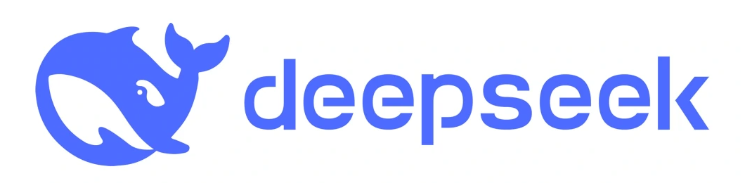

- 技术特点
  - **混合专家模型（MoE）**：将模型分成多个专家模块，每个任务仅激活少量专家，减少参数量，提升效率。
  - **多头潜在注意力机制（MLA）**：通过低秩压缩技术减少Key-Value缓存，显著提升推理效率。
  - **训练方式**：采用大规模强化学习与高质量合成数据结合，无需依赖大量标注数据。
- 应用场景
  - 自然语言处理：文本生成、翻译、情感分析等。
  - 智能对话：智能客服、聊天机器人。
  - 代码生成：支持上百种编程语言，生成、解释和修复代码。

下面是DeepSeek-R1解一个数学问题的效果：

[相关视频：video\10_1_math.mp4](video/10_1_math.mp4)


## DeepSeek 对行业的冲击

DeepSeek 的出现给 AI 领域带来了深远影响。凭借高效的推理能力、低成本的部署方案以及强大的生成能力，它打破了传统大模型的限制，让更多企业和个人用户能够享受到顶级 AI 技术。DeepSeek 不仅在通用 NLP 任务上表现卓越，还为 RAG（检索增强生成）等应用带来了新的可能性。从商业应用到学术研究，DeepSeek 正在重塑 AI 生态，为更广泛的行业提供变革性的解决方案。相较于其他大模型，具有以下显著特点：

- **高效推理**：在保证高质量生成的同时，DeepSeek 显著提升了推理速度，使其在各类任务中响应更快。
- **本地化部署**：支持离线部署，降低对云计算资源的依赖，提高数据隐私性和安全性。
- **优化的训练架构**：采用先进的模型架构和训练策略，提升生成质量和稳定性。
- **强大的推理能力**：在文本、代码、数学推理等多领域均有出色表现，拓宽了应用场景。

这些优势使得 DeepSeek 成为大规模 AI 应用中的理想选择，特别是在 RAG 等需要高效信息检索与生成的任务中。

## DeepSeek-R1 基本原理

### 思维链简介

在介绍DeepSeek-R1之前，需要先解释什么是思维链。思维链2022 年 Google 论文《Chain-of-Thought Prompting Elicits Reasoning in Large Language Models》中首次提出，通过让大模型逐步参与将一个复杂问题分解为一步一步的子问题并依次进行求解的过程可以显著提升大模型的性能。而这些推理的中间步骤就被称为思维链（Chain of Thought，CoT）。

#### CoT 结构

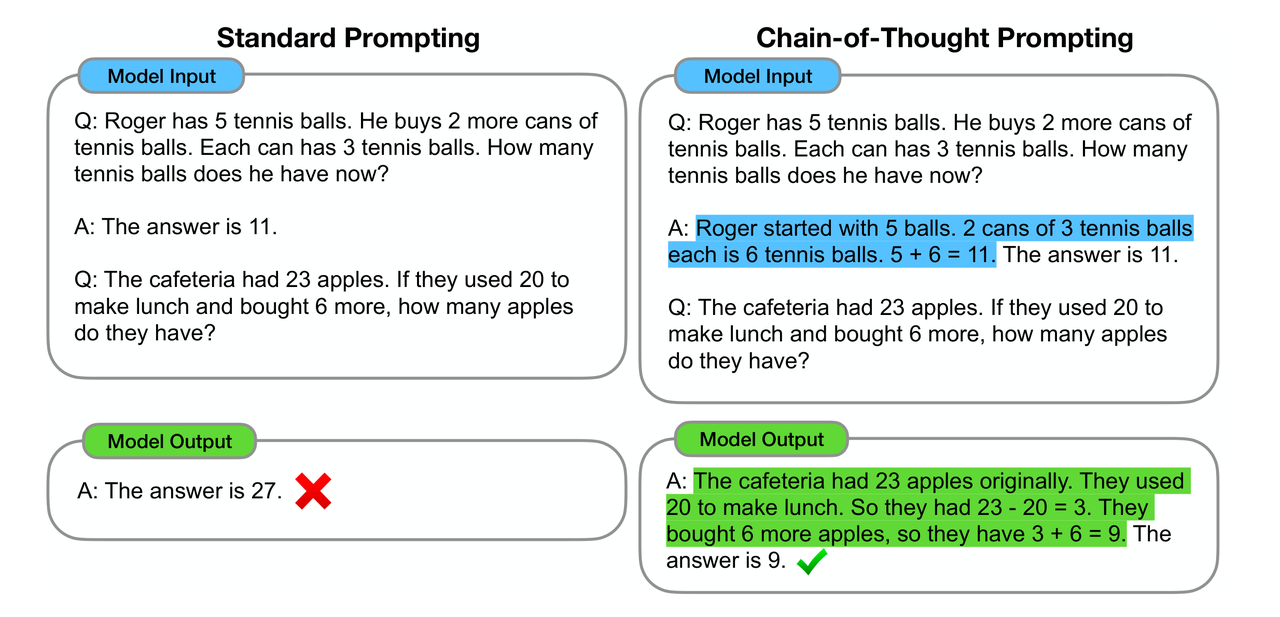

区别于传统的 Prompt 从输入直接到输出的映射 <input——>output> 的方式，CoT 完成了从输入到思维链再到输出的映射，即 <input——>reasoning chain——>output>。如果将使用 CoT 的 Prompt 进行分解，可以更加详细的观察到 CoT 的工作流程。

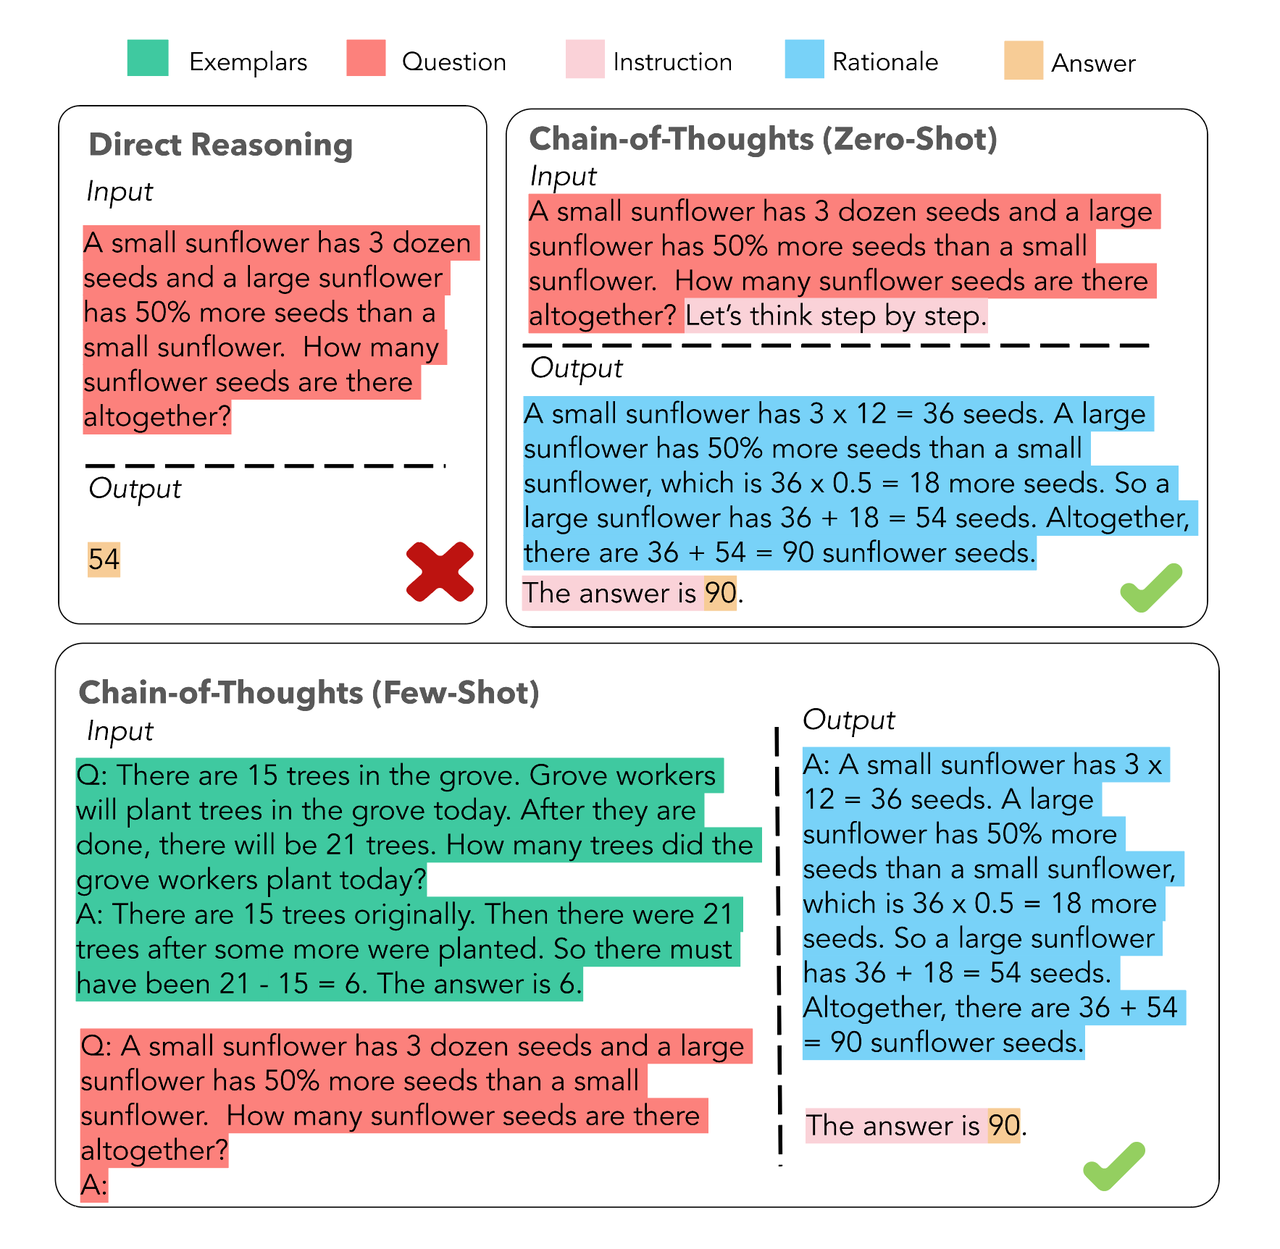

如上图所示，一个完整的包含 CoT 的 Prompt 往往由三部分组成：

- 指令（Instruction）：明确任务目标与输出格式规范（如JSON/Markdown结构化要求）；
- 逻辑（Rationale）：包含多跳推理路径、领域知识调用及中间验证步骤；
- 示例（Exemplars）：提供少样本（Few-Shot）的解题范式，每个示例包含完整的问题-推理-答案三元组。

#### CoT 分类

根据样本引导强度的差异，CoT可分为两类典型实现：：

- Zero-Shot-CoT：通过添加元提示（Meta-Prompt）如"Let's think step by step"激活模型的隐式推理能力，无需提供具体示例；
- Few-Shot-CoT：提供3-5个包含完整推理链的参考案例，引导模型通过照猫画虎类比学习生成结构化推理过程。

#### CoT优势

在工业级AI系统建设中，CoT展现出多重应用价值：

1. **复杂问题求解**：通过问题分解（Problem Decomposition）将计算资源动态分配至关键推理节点；
2. **模型可解释性**：推理链输出使开发者能定位错误节点（如数学公式误用、知识检索偏差），相比黑箱模型调试模型有据可依；
3. **跨模型泛化性**：兼容Transformer系列、MoE架构等主流模型，仅需添加提示词即可实现能力迁移；

在复杂推理任务中，思维链（CoT）可以显著提升模型的推理能力。然而，CoT 数据的获取一直高度依赖人工标注，难以大规模生成和应用。DeepSeek-R1 通过强化学习优化了这一流程，使模型能够自主生成高质量 CoT 数据，并公开了这一方法，让端到端训练更加高效可复现。此外，DeepSeek 还利用大模型生成的数据训练小模型，让小模型也具备强大的推理能力，从而降低推理成本，使高质量推理能力更易落地应用。

###  训练的过程

关于模型与流程可以简单分为4个阶段：

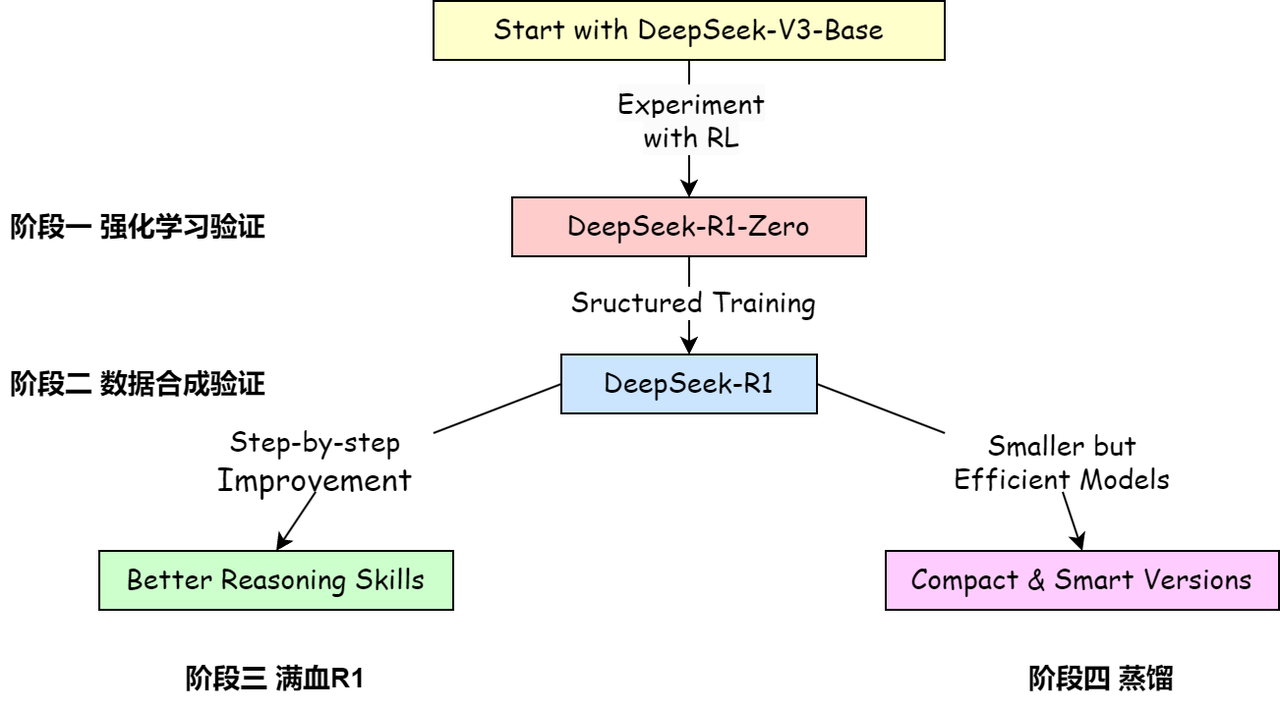

**① 阶段一**：强化学习验证，对DeepSeek-V3进行纯粹的强化学习，获得DeepSeek-R1-Zero

**② 阶段二**：数据合成模型，使用DeepSeek-R1-Zero生成数据训练DeepSeek-V3，得到DeepSeek-V3-checkpoint，并用DeepSeek-V3-checkpoint生成600k的推理数据集

**③ 阶段三**：DeepSeek-R1训练，混合推理数据以及非推理数据集（800k），对模型DeepSeek-V3进行全参数微调，获得DeepSeek-R1

**④ 阶段四**：蒸馏实验，使用与训练R1相同的混合数据集，对各开源模型（Qwen，Llama）进行全参数微调，获得DeepSeek-R1-Distill-（Qwen/Llama）-(*B)

其中需要注意的是，实验证明，只有“足够聪明”的基模型才能进行后续的强化学习训练，所以这里的基模型的选择，deepseek使用了他们本身数理能力就足够强的MoE模型，deepseek-V3作为基础进行训练。

## DeepSeek-R1 部署使用

上面介绍了DeepSeek-R1的基本原理，那我们怎么才能用起来？尤其是基于LazyLLM丰富的工具和强大的应用编排能力来定制化我们自己的DeepSeek-R1？进而充分发挥出DeepSeek-R1的能力。

### 在线模型使用

DeepSeek-R1线上模型的使用和第三讲中介绍的其它模型一样，指定`OnlineChatModule`中的模型为`DeepSeek-R1`即可。在命令行终端配置好`API-KEY`之后（这里配置的是商汤的相关API-KEY，商汤支持DeepSeek大模型的使用），就可以通过下面几行代码实现一个聊天机器人：

In [ ]:
import lazyllm
chat = lazyllm.OnlineChatModule('DeepSeek-R1')
if __name__ == '__main__':
    lazyllm.WebModule(chat, port=range(23466, 23470)).start().wait()

上面代码运行后会提供一个链接，复制到浏览器中即可打开开始聊天：

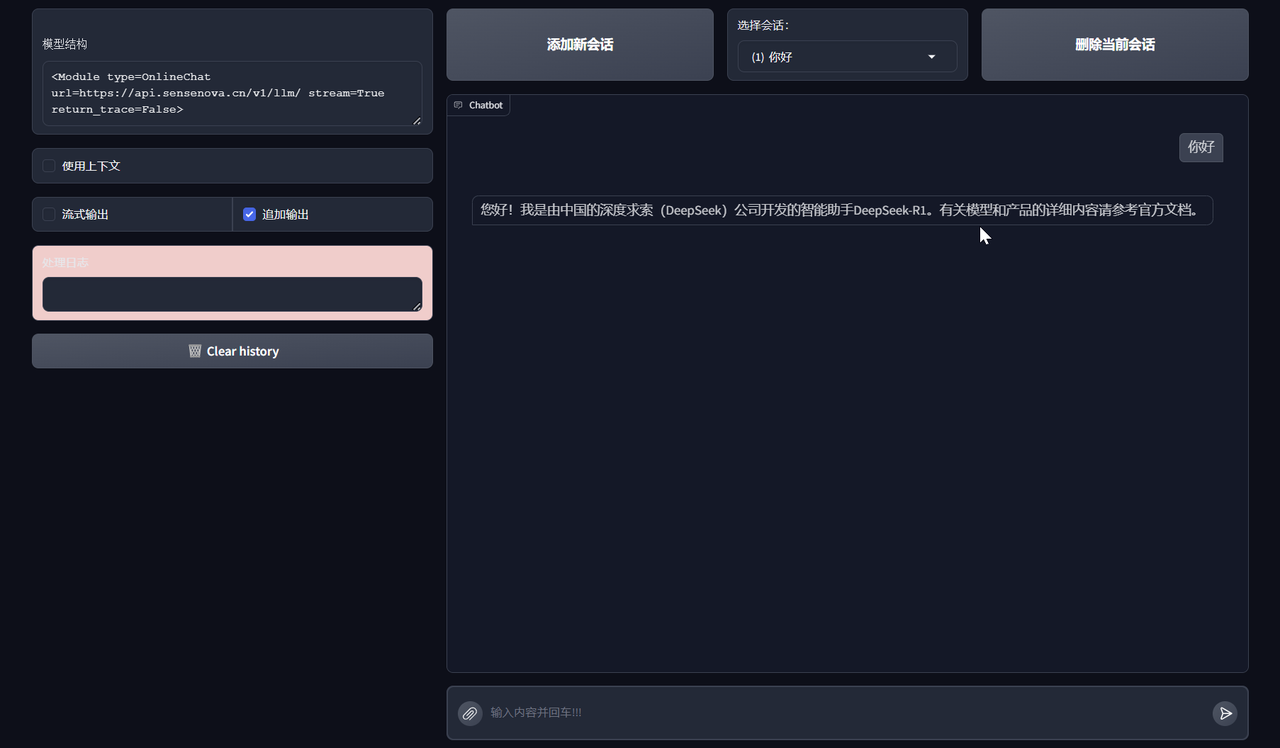

调用DeepSeek的DeepSeek-R1模型：

In [ ]:
chat = lazyllm.OnlineChatModule('deepseek-reasoner', source='deepseek')

调用阿里的DeepSeek-R1模型：

In [ ]:
chat = lazyllm.OnlineChatModule('deepseek-r1', source='qwen')

### 本地部署使用

如果您拥有足够的算力资源支持，也可以将DeepSeek R1部署到本地上。和在线模型类似，您只要利用LazyLLM中的`TrainableModule`模块，传入模型的名称“DeepSeek-R1”，即可完成模型的部署，LazyLLM会自动调用相应的工具完成部署。具体代码如下：

In [ ]:
import lazyllm
from lazyllm import deploy, launchers
chat = lazyllm.TrainableModule('DeepSeek-R1').\
            deploy_method((deploy.Vllm,{
                'tensor-parallel-size': 8,
                'pipeline-parallel-size': 2,
                'max-num-batched-tokens': 131072,
                'launcher': launchers.sco(nnode=2, ngpus=8, sync=False)
            }))
if __name__ == '__main__':
    lazyllm.WebModule(chat, port=range(23466, 23470)).start().wait()

值得注意的是，由于模型太大，涉及到跨节点（一个节点可以简单理解为用于8张A100的机器，跨节点意味着至少要两台机器，累计16张卡）部署，所以需要对参数进行配置，上面代码中：

- `tensor-parallel-size`：8，对模型进行张量并行（简单可以理解为对模型沿着数据流向方向切分成了8个小模型）；
- `pipeline-parallel-size`：2，对模型进行流水线并行（简单可以理解为对模型垂直于数据流向方向切为了2段，分为2个小模型，算上张量并行总共是2*8=16块小模型，每个小模型放到一张卡上）；
- `launcher`：用于指定启动任务的平台及算力。这里`launchers.sco`指定的是商汤的公有云平台SenseCore，对应的算力参数：
  - `nnode`：2，指定需要2个节点；
  - `ngpus`：8，指定每个节点8张计算卡；
  - `sync`：False，意味着部署命令后就不用等待了，可以继续进行其它任务，比如后面还需要部署`WebModule`的交互界面，这里就必须用False；否则它卡着等待部署任务正常结束，实际上非主动终结正常情况下部署好的任务会一直存在，所以会卡着；
- `max-num-batched-tokens`：一个批次的最大token量；该数值越大性能越好，但占用计算卡的显存资源就会越多。

LazyLLM还支持各种基础设施即服务（IaaS）平台：

- SenseCore
- Slurm
- K8S
- 裸金属

### R1遭遇滑铁卢

在前面的第二讲中，我们已经介绍了如何基于 LazyLLM 搭建一个简单的在线大模型对话系统。接下来，我们将直接对比两种不同的在线模型的效果。

In [ ]:
import lazyllm

# 指定测试数据
context = '基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。'
question = '若游戏中离，则多少分钟内不得进行配对？'

#  定义聊天角色和行为
pt = lazyllm.ChatPrompter(f"请用下面的文段的原文来回答问题\n\n### 已知文段：{context}\n\n### 问题：{question}\n")

# 初始化 OnlineChatModule
# 指定使用 SenseNova 作为聊天源（source）和 DeepSeek-R1 模型
# 传入 API_KEY 进行身份验证
# 使用定义的 ChatPrompter (p_cat) 作为模型的提示
llm = lazyllm.OnlineChatModule(source="sensenova", model="DeepSeek-R1").prompt(pt)

# 调用模型
res = llm('请告诉我结果')

# 打印模型的输出结果
print(res)

为了更清晰地对比两个模型（ DeepSeek-R1 与 Qwen2-7B ）的表现，我们从上期的CMRC2018数据集的test数据集中选取了一条阅读理解数据作为测试集。为了排除 RAG 召回文档片段对结果的影响，我们直接将阅读理解的原文作为 context，与 question 一同输入大模型，以此观察其生成效果。

In [ ]:
{
    "context": "基于《跑跑卡丁车》与《泡泡堂》上所开发的游戏，由韩国Nexon开发与发行。中国大陆由盛大游戏运营，这是Nexon时隔6年再次授予盛大网络其游戏运营权。台湾由游戏橘子运营。玩家以水枪、小枪、锤子或是水炸弹泡封敌人(玩家或NPC)，即为一泡封，将水泡击破为一踢爆。若水泡未在时间内踢爆，则会从水泡中释放或被队友救援(即为一救援)。每次泡封会减少生命数，生命数耗完即算为踢爆。重生者在一定时间内为无敌状态，以踢爆数计分较多者获胜，规则因模式而有差异。以2V2、4V4随机配对的方式，玩家可依胜场数爬牌位(依序为原石、铜牌、银牌、金牌、白金、钻石、大师) ，可选择经典、热血、狙击等模式进行游戏。若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。开放时间为暑假或寒假期间内不定期开放，8人经典模式随机配对，采计分方式，活动时间内分数越多，终了时可依该名次获得奖励。",
    "question": "若游戏中离，则多少分钟内不得进行配对？",
    "answers": "4分钟"
}

其中，Prompt 的设计如下：

In [ ]:
f"请用下面的文段的原文来回答问题\n\n### 已知文段：{context}\n\n### 问题：{question}\n"

下面为 DeepSeek-R1 模型与 Qwen2-7B 模型的运行结果。可以看到Qwen2-7B 的回答更简洁、更贴近标准答案（"4分钟"），在需要精准提取关键信息的任务中更优；而DeepSeek-R1 提供了引用 + 解释，虽然更详细，但存在冗余，更适合需要上下文支撑的任务。

|      | **Qwen2-7B**                        | **DeepSeek-R1**                                              |
| ---- | ----------------------------------- | ------------------------------------------------------------ |
| 回答 | `若游戏中离，则4分钟内不得进行配对` | `根据提供的文段原文: **"若游戏中离，则4分钟内不得进行配对(每次中离+4分钟)。"** 因此，若游戏中离，**4分钟**内不得进行配对。` |

 让我们用DeepSeek-R1跑一遍评测，并结合上期结果来进行对比：

| **模型**                | **精确匹配率**  | **语义相似度**    | **原文包含度**  |
| ----------------------- | --------------- | ----------------- | --------------- |
| Internlm2-Chat-7B       | 2.10%(21)       | 74.51%(746.6)     | 5.19%(52)       |
| DeepSeek-V3             | 5.29%(53)       | 74.85%(750.0)     | 15.17%(152)     |
| DeepSeek-R1             | 2.3%（23）      | 69.62%（697.56）  | 7.78%（78）     |
| Internlm2-Chat-7B训练后 | **39.72%**(398) | **86.19%**(863.6) | **94.91%**(951) |

从上表中，我们可以看到DeepSeek-R1在语义相似度上得分最低，同时精确匹配度和原文包含度也仅比小模型Internlm2-Chat-7B略好。说明DeepSeek-R1在阅读理解信息抽取任务中表现不好。

老话说要取长补短，那么DeepSeek-R1的长在哪里？该模型一个明显的优势之一是数学推理能力。如评价报告所示，它在AIME 2024 和 MATH-500 上都有明显的优势：

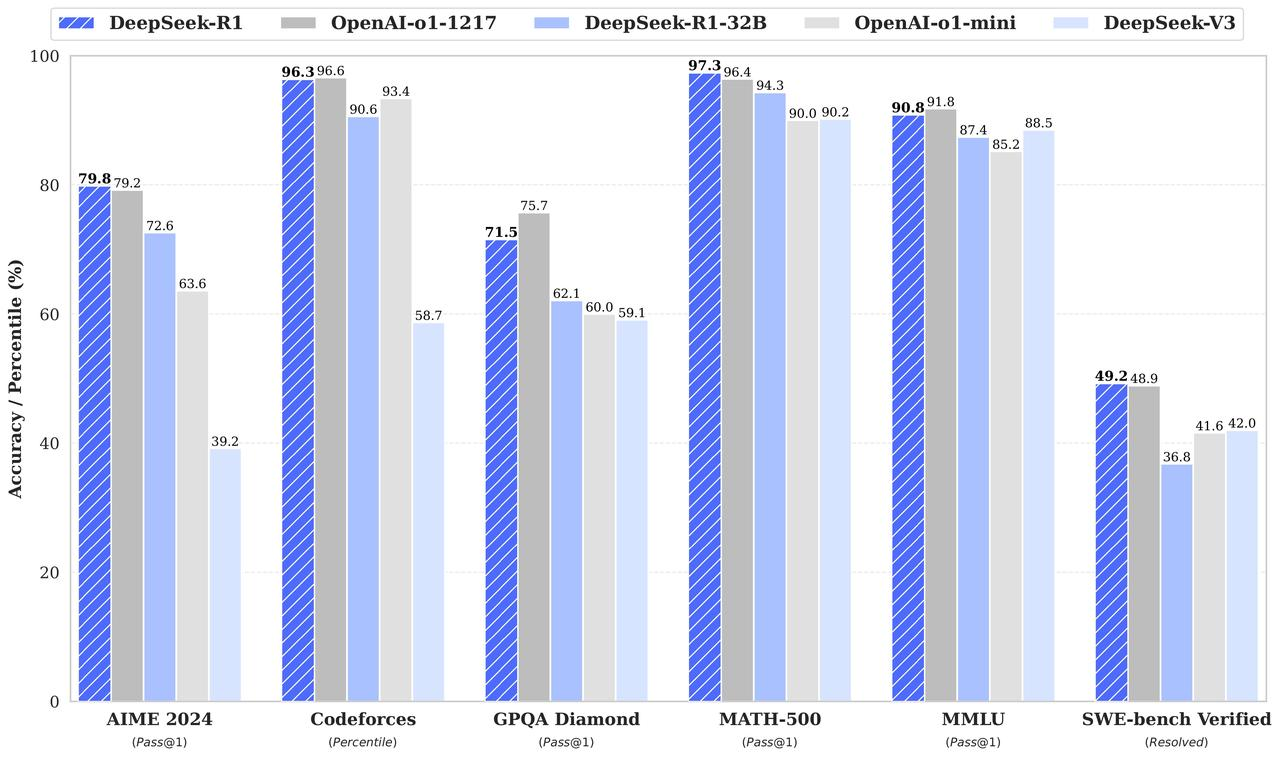

那么有什么办法可以将DeepSeek-R1擅长的数学能力迁移到我们的上期教程中的小模型上来呢？与此同时还需要保证我们小模型的阅读理解能力。一个比较常用的方法是——蒸馏！

## Deepseek R1 蒸馏详解

上一节我们发现DeepSeek-R1在特定任务下的阅读理解的内容提取上表现不好，于是我们想取长补短，将DeepSeek-R1的强大数学推理能力迁移到一个小模型上，而实现迁移的方法是知识蒸馏！那么知识蒸馏的原理是什么？

### 蒸馏原理

所谓“知识蒸馏”，简单来讲就是通过“**某种方式**”来让小模型学习到大模型的“**某方面优势**”。这里的“某方面优势”对于R1来说，就是R1的**推理能力**，而“某种方式”简单来讲就是**监督微调**（Supervised Fine-Tuning，即SFT）。而监督微调的数据，就是R1推理时生成的思维链。基本思路如下：

1. 选定某领域数据集`{question:"xxxxx?", answer:"yyyyy"}`，取其中的question：`"xxxxx?"`利用DeepSeek R1模型进行推理，对推理结果进行筛选和清晰，得到R1带思维链数据`R1_CoT_Ans:"wwwwww"`。
2. 将数据集中的原问题`"xxxxx?"`与R1的思维链数据组成新的数据集：`{question:"xxxxx?", R1_CoT_Ans:"wwwwww"}`，作为微调小模型的数据集，即蒸馏数据集。
3. 利用新数据集`{question:"xxxxx?", R1_CoT_Ans:"wwwwww"}`对小模型进行监督微调，并对微调后的小模型进行评测，比较微调前后模型的效果。

清楚蒸馏的基本原理后，我们就可以设计我们的蒸馏方案了。

### 蒸馏方案

我们使用DeepSeek-R1来对小模型进行蒸馏，其过程大致如下图所示：首先我们选取 GSM8K 数据集，使用其训练集中的题目来不断喂给DeepSeek-R1来获得用于训练的问答对，在获得蒸馏训练集后为了查看思维链在其中的效果，我们还单独剔除了数据集中的思维链来作为另外一个训练集，基于这两个训练集分别微调出两个小模型，最后我们对微调后的两个小模型、DeepSeek-R1以及微调前的小模型进行评测以查看提升效果。

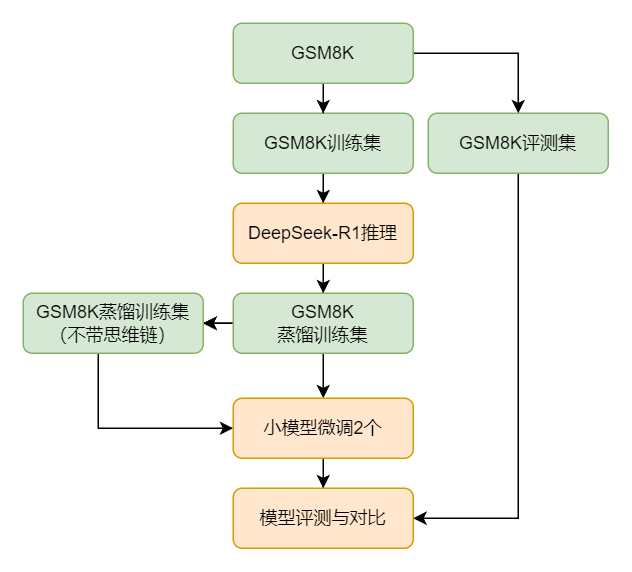
#### 1.数据准备

这里我们选用 **GSM8K**（Grade School Math 8K），该数据集由 OpenAI 团队构建，是一个用于数学问题求解的文本数据集，其中包含了8000多个小学数学水平的问题（训练集：7473题，测试集：1319题）。这些问题主要涉及基本的算术运算，如加法、减法、乘法和除法，以及一些简单的数学应用题。每个问题都附有自然语言形式的答案，这些答案不仅提供了最终的结果，还详细解释了解题的步骤和过程。下面是该数据集中的一条数据：

In [ ]:
{
    "question": "James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?",
    "answer": "He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*60=<<9*60=540>>540 meters\n#### 540"
}

可以看到该数据集中答案都以 \n#### ans 开头，该特性方便我们对模型的推理效果有一个明确的数值评价。

#### 2.蒸馏数据

接下来我们对GSM8K数据集中的训练数据集进行重建，获得用于蒸馏小模型的训练集。数据集重建的目的在于：我们希望获得一个带有思维链的且最终提供正确格式和正确答案的回答。主要过程就是：

1. 提取 GSM8K 数据集的训练集：7473个题目，去除其中的回答，仅保留提问。
2. 将 7473 个题目喂给 DeepSeek-R1，保存其对应的输出来作为新的回答，即实现问答对的重建。

以下几个关键点要注意：

1. DeepSeek-R1 要明确让它将答案放到`'\\boxed{true_answer}'` 中，所以需要对它设置一个Prompt：`<｜begin▁of▁sentence｜>You are a math problem solver. Provide the final answer in a boxed format using \\boxed{{answer}}.\n<｜User｜>{question}<｜Assistant｜>`，其中 `question` 就是放置题目的地方；
2. 为了提升推理的速度，需要尽量将并发量提高（可根据供应商的并发量限制来最大化设置）；
3. DeepSeek-R1 生成的答案需要满足一定的标准才能被保存，具体要求如下：
   1. 推理的答案中必须包含标准答案，且满足格式：`'\\boxed{{{true_answer}}}'`
   2. 推理的答案中需要包含思维链，筛选标志：`</think>`
4. 保存答案的策略：如果不满足上述两个保存的条件，那么该问题就会被记录下来，完成一轮推理后再把记录下来的所有问题再重新进行一轮。该过程会至少重复 15次。

最终得到构造的满足需求的问答对如下：

In [ ]:
{
    "instruction": "Mel is three years younger than Katherine.  When Katherine is two dozen years old, how old will Mel be in years?",
    "output": "<think>\nOkay, let's see. The problem says Mel is three years younger than Katherine. So, if I figure out Katherine's age first, then I can subtract three to get Mel's age. \n\nThe question is asking, when Katherine is two dozen years old, how old will Mel be? Hmm, a dozen is 12, so two dozen would be 24. Wait, is that right? Yeah, 12 times 2 is definitely 24. So Katherine will be 24 years old at that time.\n\nSince Mel is three years younger, I need to subtract 3 from Katherine's age. Let me do the math here: 24 minus 3 equals 21. So that should be Mel's age when Katherine is 24. Let me double-check. If Mel is always three years younger, then no matter when, the difference stays the same. So when Katherine is 24, subtracting 3 gives 21. Yeah, that makes sense. I think that's the answer.\n</think>\n\nWhen Katherine is two dozen (24) years old, Mel, being three years younger, will be:\n\n\\boxed{21}",
    "input": ""
}

其中：

- `instruction` 是GSM8K中的 `question` 问题；
- `output`是 DeepSeek-R1 输出的，带思维链的且格式和答案都正确的回答；
- `input` 为空，主要微调训练的时候需要该字段；

#### 3.微调模型

- **技术选型**：和上期教程一样采用 **LoRA（Low-Rank Adaptation）** 实现轻量微调，显著降低计算开销；
- **参数配置**：

| **参数** | **Model**         | **Epochs** | **Batch-size** | **GPUs**  | **Gradient Accumulation step** | **learning_rate** | **lora_rank** |
| -------- | ----------------- | ---------- | -------------- | --------- | ------------------------------ | ----------------- | ------------- |
| **说明** | InternLM2-7B-Chat | 2          | 16             | 8（A800） | 1                              | 1.00E-04          | 8             |

这里在微调模型的过程中，主要采用了 基于DeepSeek-R1 蒸馏出的数据集。同时，为了验证其中的思维链是否真的有效，以作为对比，我们可以将该数据再次处理，去除其中的思维链部分。也就是说在微调部分，需要微调出两个模型：一个基于蒸馏出的数据集，另外一个是基于去除掉思维链的蒸馏数据集。

#### 4.模型评测

在获得微调的模型之后，需要对模型进行评测。这里我们采用如下标准：

- **评测标准**：
  - 数值正确性：生成答案与标准答案完全匹配；
  - 格式合规性：答案需以 `\\boxed{...}` 包裹。
- **对比实验设计**：
  - 蒸馏前模型：未经优化的原始小模型；
  - 蒸馏后模型1：基于完整蒸馏数据（带思维链）微调的模型；
  - 蒸馏后模型2：基于不带思维链的蒸馏数据微调的模型；
  - 基准模型：DeepSeek-R1 作为性能上限参考。

## Deepseek-R1 蒸馏实战

这里我们基于LazyLLM来将上述流程进行实现，基于 LazyLLM 可以轻松一键实现微调、部署、推理和评测。

### 1.获取数据

首先我们需要获得数据集：[GSM8K](https://www.modelscope.cn/datasets/modelscope/gsm8k)。代码见[链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter10/distill_deepseek_r1.py#L21)。

In [ ]:
import os
import json
from modelscope.msdatasets import MsDataset
def build_data_path(file_name):
    data_root = os.path.join(os.getcwd(), 'dataset')
    if not os.path.exists(data_root):
        os.makedirs(data_root)
    save_path = os.path.join(data_root, file_name)
    return save_path
def get_dataset():
    train_path = build_data_path('train_set.json')
    eval_path = build_data_path('eval_set.json')
    ds = MsDataset.load('modelscope/gsm8k', subset_name='main')
    ds = ds.rename_column('question', 'instruction').rename_column('answer', 'output')
    with open(train_path, 'w') as file:
        json.dump(ds['train'].to_list(), file, ensure_ascii=False, indent=4)
    with open(eval_path, 'w') as file:
        json.dump(ds['test'].to_list(), file, ensure_ascii=False, indent=4)
    return train_path, eval_path

在上面代码中：

- 创建数据目录：调用 `build_data_path` 生成存储目录，定义训练集路径 `train_path` 和评测集路径 `eval_path`。
- 数据集转换：
  - 加载数据：通过 ModelScope API 获取 GSM8K 数据集；
  - 字段映射：将原始字段 `question` → `instruction`，`answer` → `output`，适配后续微调需求。
- 保存数据：将处理后的训练集和评测集分别存入 `train_path` 和 `eval_path`。

经过以上步骤，我们就完成了对数据集 GSM8K的预处理工作。

### 2.蒸馏数据

接下来我们基于预处理好的训练集，将它处理后喂给DeepSeek-R1来实现数据的蒸馏，以构造出新的训练集。

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter10/distill_deepseek_r1.py#L12)


In [ ]:
import json
from lazyllm import warp

def load_data(data_path):
    with open(data_path, 'r') as file:
        dataset = json.load(file)
    return dataset

def save_res(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

def distill_dataset(data_path, model=None, demo=False):
    inputs = load_data(data_path)[:1] if demo else load_data(data_path)
    with warp(_concurrent=1) as wp:
        wp.func = model
    res_list = []
    try_n = 0
    while inputs:
        print(">>>" * 12, f"{try_n+1} times left: ", len(inputs))
        querys = [item['instruction'] for item in inputs]
        results = wp(querys)
        valid_data, inputs = filter(inputs, results)
        res_list.extend(valid_data)
        try_n += 1
        if try_n == 15:
            break
    res_list = res_list * 120 if demo else res_list
    distilled_train_set_path = build_data_path('distilled_train_data.json')
    save_res(res_list, distilled_train_set_path)
    save_res(inputs, build_data_path('left_data.json'))
    return distilled_train_set_path

上面代码中，我们定义了一个 `distill_dataset`函数 来实现对数据的蒸馏：

- 加载数据：`distill_dataset` 调用 `load_data` 加载预处理后的训练集，支持通过 `demo` 参数快速调试（仅加载单条数据）。
- 并发推理：基于 LazyLLM 的 `warp` 工作流并发调用 DeepSeek-R1 模型（通过 `_concurrent` 控制并发量）。
- 迭代筛选：
  - 提取问题 (`instruction`) 并触发推理流程；
  - 使用 `filter` 函数筛选符合标准的答案（含 `\\boxed{{true_answer}}` 和  `</think>`标签），存入 `res_list`；
  - 未通过的数据作为新输入循环推理，最多重试 **15 次**。
- 结果保存：最终输出合格数据 `distilled_train_data.json` 和失败记录 `left_data.json`。
- 关键参数：
  - `_concurrent`：控制并发推理线程数；
  - `demo`：调试模式开关（加载单条数据）；
  - 重试上限：15 次（过滤低质量样本）。

下面代码是 filter 的实现细节(对DeepSeek-R1的推理结果进行筛选，只保留带有思维链，且答案和格式都正确的结果)，[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter10/distill_deepseek_r1.py#L60)：

In [ ]:
def filter(inputs, results):
    valid = []
    retry = []
    for i, item in enumerate(inputs):
        true_v = item['output'].split('\n#### ')[-1].strip()
        if f'\\boxed{{{true_v}}}' in results[i] and '</think>' in results[i]:
            valid.append({'instruction': item['instruction'], 'output': results[i], 'input': ''})
        else:
            retry.append(item)
    return valid, retry

### 3.微调模型

在上一步获得训练集的基础上，我们可以基于LazyLLM来实现微调、推理和评测。和上期教程一样采用 LoRA（Low-Rank Adaptation） 实现轻量微调，代码如下（ [GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter10/distill_deepseek_r1.py#L97) ）：

In [ ]:
import lazyllm
from lazyllm import finetune, deploy, launchers

# 获取数据
train_set_path, eval_set_path = get_dataset()
eval_set = load_data(eval_set_path)

# 蒸馏数据
teacher_model = lazyllm.OnlineChatModule('DeepSeek-R1')
sft_data_path = distill_dataset(train_set_path, teacher_model)

# 微调模型
infer_data = [item['instruction'] for item in eval_set]
student_model = lazyllm.TrainableModule('internlm2-chat-7b')\
    .mode('finetune')\
    .trainset(sft_data_path)\
    .finetune_method((finetune.llamafactory, {
        'learning_rate': 1e-4,
        'cutoff_len': 5120,
        'max_samples': 20000,
        'val_size': 0.01,
        'per_device_train_batch_size': 2,
        'num_train_epochs': 2.0,
        'launcher': launchers.sco(nnode=1, nproc=8, ngpus=8)
    }))\
    .prompt(dict(system='You are a helpful assistant.', drop_builtin_system=True))\
    .deploy_method(deploy.Vllm)
student_model._prompt._soa = '<|im_start|>assistant\n\n<think>'
student_model.evalset(infer_data)
student_model.update()

## 评测模型
score = caculate_score(eval_set, student_model.eval_result)
print("All Done. Score is: ", score)

上面代码中，获取数据和蒸馏数据已经在前面内容介绍，这里我们直接来看微调模型：

- 数据准备：从评测集抽取 `instruction` 作为推理数据集 `infer_data`，并绑定为 `.evalset(infer_data)`。
- 我们使用了LazyLLM中的`TrainableModule`模块来对微调进行配置：
  - 传入模型名参数：`'internlm2-chat-7b'`，表示要微调的小模型，如果本地没有会自动下载；
  - 设置模式为微调 `.mode('finetune')`；
  - 同时设置了训练集为上一步蒸馏的数据：`.trainset(sft_data_path)`；
  - 通过`.finetune_method`设置微调的基本参数：
    - 使用的微调引擎是`llamafactory`;
    - 相关关键参数有：学习率learning_rate、数据最大截断长度cutoff_len、训练集最大的样本数max_samples、验证集占训练集的百分比val_size、每个设备上的训练批次大小per_device_train_batch_size、训练的轮次总数num_train_epochs、启动训练的平台及参数launcher（这里平台用的是商汤的公有云SCO，设置了8卡来微调这个模型）；
  - 通过`.prompt`来配置系统的Prompt;
  - 通过`deploy_method`来配置了部署时候用的推理引擎是`vllm`
  - 另外我们还额外单独配置了Prompt中的soa特殊标记，为其中最后加了`<think>`标签；
- 配置好参数后，我们使用`.update()`来一键实现：微调、部署、推理。
- 等待上述流程完成后，推理的结果会放到`student_model.eval_result`中；

### 4.模型评测

在获得了评测集的推理结果之后，我们可以实现一个`caculate_score`对其结果进行评测：

In [ ]:
import re

def extract_boxed_content(text):
    pattern = r'boxed{((?:[^{}]*|{.*?})*)}'
    contents = re.findall(pattern, text)
    return contents

def caculate_score(eval_set, infer_set):
    assert len(eval_set) == len(infer_set)
    score = 0
    for index, eval_item in enumerate(eval_set):
        output = infer_set[index]
        if 'boxed{' in output:
            res = extract_boxed_content(output)
            res = list(set(res))
            res = res[0] if len(res) == 1 else res
            if type(res) is list:
                continue
            true_v = eval_item['output'].split('\n#### ')[-1].strip()
            if true_v == res.strip():
                score += 1
    return f'{score}/{len(eval_set)}, {round(score/len(eval_set),4)*100}%'

上述代码中主要从推理结果中捕获boxed所包含的正确答案，并和标准答案做对比，相等就可以累加一分。最后以字符串的方式返回总得分和分数占比。至此，这就是基于LazyLLM的对DeepSeek-R1蒸馏小模型的实现，完整的代码脚本详见：[LazyLLM/examples/distill_deepseek_r1.py](https://github.com/LazyAGI/LazyLLM/blob/main/examples/distill_deepseek_r1.py)

[相关视频：video\10_2_Distill_DeepSeek.mp4](video/10_2_Distill_DeepSeek.mp4)



## DeepSeek-R1 蒸馏效果

我们将评测结果汇总如下：

| **模型**           | **InternLM2-7B-Chat**【原始】 | **InternLM2-7B-Chat**【蒸馏后-不带思维链】 | **InternLM2-7B-Chat**【蒸馏后】 | **DeepSeek-R1**【教师模型】 |
| ------------------ | ----------------------------- | ------------------------------------------ | ------------------------------- | --------------------------- |
| **答对题数**       | 331                           | 839                                        | 951                             | 1201                        |
| **准确率(1319题)** | 25.09%                        | 63.61%                                     | 72.10%                          | 91.05%                      |

基于上面表格我们可以看出：

1. **基础蒸馏增益**：无思维链的蒸馏使准确率从25.09%跃升至63.61%，**绝对提升达38.5个百分点**，证明基础蒸馏是有效的；
2. **思维链附加值**：引入CoT机制后准确率再提升8.5个百分点，**验证思维链对知识迁移的强化作用；**
3. **师生差距**：学生模型（72.1%）与教师模型（91.05%）存在18.95个百分点的性能差，**揭示模型容量对推理能力的关键影响；**
4. **规模效率比**：7B蒸馏模型达到671B教师模型79.2%的准确率水平，**以近1/100参数量实现4/5的性能表现！**

## RAG 文理助手系统搭建

前面的蒸馏主要单独基于数学推理的数据进行的，我们的目标是要强化RAG中的生成模型的能力，所以这里我们不仅需要强化数学推理能力，而且还需要尽可能去保留模型的阅读理解能力。所以，这里我们将基于InternLM2-7B-Chat重新使用混合数据集（本期带思维链的GSM8k数据集和上期的CMRC2018训练集）来进行上述的微调过程。下面是混合训练后的评测结果：

| 任务（数据集）                             | **阅读理解信息抽取能力**（CMRC2018） | **数学推理能力**（GSM8K） |                 |                |
| ------------------------------------------ | ------------------------------------ | ------------------------- | --------------- | -------------- |
| **模型**                                   | **精确匹配率**                       | **语义相似度**            | **原文包含度**  | 准确度         |
| Internlm2-Chat-7B                          | 2.10%(21)                            | 74.51%(746.6)             | 5.19%(52)       | 25.09%（331）  |
| DeepSeek-R1                                | 2.3%（23）                           | 69.62%（697.56）          | 7.78%（78）     | 91.05%（1201） |
| Internlm2-Chat-7B训练后（仅CMRC2018数据）  | **39.72%**(398)                      | **86.19%**(863.6)         | **94.91%**(951) | -（-）         |
| Internlm2-Chat-7B训练后（仅GSM8K蒸馏数据） | -(-)                                 | -(-)                      | -(-)            | 72.10%（951）  |
| Internlm2-Chat-7B训练后(混合数据)          | **39.22%**(393)                      | **86.22%**(863.9)         | **93.71%**(939) | 73.24%（966）  |

评测过程：

[相关视频：video\10_3_Math-Zh-Eval.mp4](video/10_3_Math-Zh-Eval.mp4)

让我们基于之前教程中的带数据流的RAG来构建我们的文理助手吧。代码如下所示（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter10/math_chinese_rag.py#L1)）：

In [ ]:
import lazyllm
from lazyllm import bind
from lazyllm.tools import IntentClassifier

template = "请用下面的文段的原文来回答问题\n\n### 已知文段：{context}\n\n### 问题：{question}\n"
base_model = 'path/to/internlm2-chat-7b-chinese-math2'
base_llm = lazyllm.TrainableModule(base_model)

# 文档加载
documents = lazyllm.Document(dataset_path="path/to/cmrc2018/data_kb")

with lazyllm.pipeline() as ppl:
    # 检索组件定义
    ppl.retriever = lazyllm.Retriever(doc=documents, group_name="CoarseChunk", similarity="bm25_chinese", topk=3)
    ppl.formatter = (lambda nodes, query: template.format(context="".join([node.get_content() for node in nodes]), question=query)) | bind(query=ppl.input)
    # 生成组件定义
    ppl.llm = base_llm

with IntentClassifier(lazyllm.OnlineChatModule()) as ic:
    ic.case['Math', base_llm]
    ic.case['Default', ppl]

lazyllm.WebModule(ic, port=23496).start().wait()

上面代码中：

- 我们引入一个意图分类器`IntentClassifier`来识别用户的意图，这里用到了一个在线的大模型，意图分类器能判断用户输入的意图来派发到不同的分支，这里我们设计了两个分支：
  - 'Math'分支：用于进行数学计算，直接调用我们蒸馏DeepSeek-R1的小模型；
  - 'Default'分支：用于进行RAG的任务，它调用了我们在之前教程中设计的基于数据流的RAG；
  - 这里两个分支用到的大模型是同一个——我们本期教程微调出的具有阅读理解能力和数学推理能力（基于蒸馏）的小模型。

让我们启动起来，看看效果吧：

[相关视频：video\10_4_RAG-Math-ZH.mp4](video/10_4_RAG-Math-ZH.mp4)


- 上面视频中的问题来自于GSM8K和CMRC2018的评测集（注意训练集和评测集是完全隔离的！），我们可以看到随便抽取几个问题到我们的RAG系统中，得到的回答与评测集的标准答案是一致的（除了第一个问题线上模型把用户的意图给识别错了，其他都还行）。

## 参考文献

[Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/pdf/2201.11903)

[Igniting Language Intelligence: The Hitchhiker’s Guide From Chain-of-Thought Reasoning to Language Agents](https://arxiv.org/pdf/2311.11797)

[DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning](https://arxiv.org/pdf/2501.12948)